In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 深度卷积神经网络（AlexNet）

### 模型设计

在AlexNet的第一层，卷积窗口的形状是 $11\times11$。
由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。
第二层中的卷积窗口形状被缩减为 $5\times5$，然后是 $3\times3$。
此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为 $3\times3$、步幅为2的最大池化层。
而且，AlexNet的卷积通道数目是LeNet的10倍。

在最后一个卷积层后有两个全连接层，分别有4096个输出。
这两个巨大的全连接层拥有将近1GB的模型参数。
由于早期GPU显存有限，原版的AlexNet采用了双数据流设计，使得每个GPU只负责存储和计算模型的一半参数。
幸运的是，现在GPU显存相对充裕，所以我们现在很少需要跨GPU分解模型（因此，我们的AlexNet模型在这方面与原始论文稍有不同）。

### 激活函数

此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数。
一方面，ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。
另一方面，当使用不同的参数初始化方法时，ReLU激活函数使训练模型更加容易。
当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。
相反，ReLU激活函数在正区间的梯度总是1。
因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。

### 容量控制和预处理

AlexNet通过dropout（ :numref:`sec_dropout` ）控制全连接层的模型复杂度，而LeNet只使用了权重衰减。
为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色。
这使得模型更健壮，更大的样本量有效地减少了过拟合。
我们将在 :numref:`sec_image_augmentation` 中更详细地讨论数据扩充。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里，我们使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),   # 输入1通道，输出96通道
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，池化层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过度拟合
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

[**我们构造一个**]高度和宽度都为224的(**单通道数据，来观察每一层输出的形状**)。
它与 :numref:`fig_alexnet` 中的AlexNet架构相匹配。


In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'Output shape:\t', X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

## 读取数据集

尽管本文中AlexNet是在ImageNet上进行训练的，但我们在这里使用的是Fashion-MNIST数据集。因为即使在现代GPU上，训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。
将AlexNet直接应用于Fashion-MNIST的一个问题是，[**Fashion-MNIST图像的分辨率**]（$28 \times 28$像素）(**低于ImageNet图像。**)
为了解决这个问题，(**我们将它们增加到 $224 \times 224$**)（通常来讲这不是一个明智的做法，但我们在这里这样做是为了有效使用AlexNet结构）。
我们使用 `d2l.load_data_fashion_mnist` 函数中的 `resize` 参数执行此调整。


In [3]:
def get_dataloader_workers():
       return 0 # windows上容易引发问题。

In [4]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)  # 整合多个操作，但是这里只有一个
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=False)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=0),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=0))

In [5]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

## [**训练AlexNet**]

现在，我们可以开始训练AlexNet了。与 :numref:`sec_lenet` 中的LeNet相比，这里的主要变化是使用更小的学习速率训练，这是因为网络更深更广、图像分辨率更高，训练卷积神经网络就更昂贵。


In [7]:
torch.cuda.set_device(0)

loss 0.329, train acc 0.880, test acc 0.876
2511.9 examples/sec on cuda:0


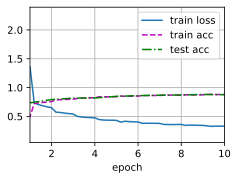

In [9]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* AlexNet的结构与LeNet相似，但使用了更多的卷积层和更多的参数来拟合大规模的ImageNet数据集。
* 今天，AlexNet已经被更有效的结构所超越，但它是从浅层网络到深层网络的关键一步。
* 尽管AlexNet的代码只比LeNet多出几行，但学术界花了很多年才接受深度学习这一概念，并应用其出色的实验结果。这也是由于缺乏有效的计算工具。
* Dropout、ReLU和预处理是提升计算机视觉任务性能的其他关键步骤。

## 练习

1. 试着增加迭代周期。对比LeNet的结果有什么不同？为什么？
1. AlexNet对于Fashion-MNIST数据集来说可能太复杂了。
    1. 尝试简化模型以加快训练速度，同时确保准确性不会显著下降。
    1. 设计一个更好的模型，可以直接在 $28 \times 28$ 图像上工作。
1. 修改批量大小，并观察模型精度和GPU显存变化。
1. 分析了AlexNet的计算性能。
    1. 在AlexNet中主要是哪部分占用显存？
    1. 在AlexNet中主要是哪部分需要更多的计算？
    1. 计算结果时显存带宽如何？
1. 将dropout和ReLU应用于LeNet-5，效果有提升吗？再试试预处理会怎么样？


# 含并行连结的网络（GoogLeNet）
:label:`sec_googlenet`

在2014年的ImageNet图像识别挑战赛中，一个名叫*GoogLeNet* :cite:`Szegedy.Liu.Jia.ea.2015` 的网络结构大放异彩。
GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。
这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。
毕竟，以前流行的网络使用小到 $1 \times 1$ ，大到 $11 \times 11$ 的卷积核。
本文的一个观点是，有时使用不同大小的卷积核组合是有利的。
在本节中，我们将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，但是现在有了更好的训练算法，这些特性不是必要的。


## (**Inception块**)

在GoogLeNet中，基本的卷积块被称为*Inception块*（Inception block）。这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

![Inception块的结构。](http://d2l.ai/_images/inception.svg)
:label:`fig_inception`

如 :numref:`fig_inception` 所示，Inception块由四条并行路径组成。
前三条路径使用窗口大小为 $1\times 1$、$3\times 3$ 和 $5\times 5$ 的卷积层，从不同空间大小中提取信息。
中间的两条路径在输入上执行 $1\times 1$ 卷积，以减少通道数，从而降低模型的复杂性。
第四条路径使用 $3\times 3$ 最大池化层，然后使用 $1\times 1$ 卷积层来改变通道数。
这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道的数量。


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    # `c1`--`c4` 是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

那么为什么GoogLeNet这个网络如此有效呢？
首先我们考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。
同时，我们可以为不同的滤波器分配不同数量的参数。


## [**GoogLeNet模型**]

如 :numref:`fig_inception_full` 所示，GoogLeNet 一共使用 9 个Inception块和全局平均池化层的堆叠来生成其估计值。Inception块之间的最大池化层可降低维度。
第一个模块类似于 AlexNet 和 LeNet，Inception块的栈从VGG继承，全局平均池化层避免了在最后使用全连接层。

![GoogLeNet结构。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/inception-full.svg?raw=1)
:label:`fig_inception_full`

现在，我们逐一实现GoogLeNet的每个模块。第一个模块使用 64 个通道、 $7\times 7$ 卷积层。


In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2,
                                           padding=1))

第二个模块使用两个卷积层：第一个卷积层是 64个通道、 $1\times 1$ 卷积层；第二个卷积层使用将通道数量增加三倍的 $3\times 3$ 卷积层。
这对应于 Inception 块中的第二条路径。


In [ ]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第三个模块串联两个完整的Inception块。
第一个 Inception 块的输出通道数为 $64+128+32+32=256$，四个路径之间的输出通道数量比为 $64:128:32:32=2:4:1:1$。
第二个和第三个路径首先将输入通道的数量分别减少到 $96/192=1/2$ 和 $16/192=1/12$，然后连接第二个卷积层。第二个 Inception 块的输出通道数增加到 $128+192+96+64=480$，四个路径之间的输出通道数量比为 $128:192:96:64 = 4:6:3:2$。
第二条和第三条路径首先将输入通道的数量分别减少到 $128/256=1/2$ 和 $32/256=1/8$。


In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第四模块更加复杂，
它串联了5个Inception块，其输出通道数分别是 $192+208+48+64=512$ 、 $160+224+64+64=512$ 、 $128+256+64+64=512$ 、 $112+288+64+64=528$ 和 $256+320+128+128=832$ 。
这些路径的通道数分配和第三模块中的类似，首先是含 $3×3$ 卷积层的第二条路径输出最多通道，其次是仅含 $1×1$ 卷积层的第一条路径，之后是含 $5×5$ 卷积层的第三条路径和含 $3×3$ 最大池化层的第四条路径。
其中第二、第三条路径都会先按比例减小通道数。
这些比例在各个 Inception 块中都略有不同。


In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五模块包含输出通道数为 $256+320+128+128=832$ 和 $384+384+128+128=1024$ 的两个Inception块。
其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。
需要注意的是，第五模块的后面紧跟输出层，该模块同 NiN 一样使用全局平均池化层，将每个通道的高和宽变成1。
最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。


In [ ]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

GoogLeNet 模型的计算复杂，而且不如 VGG 那样便于修改通道数。
[**为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96**]，这简化了计算。下面演示各个模块输出的形状变化。


In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

和以前一样，我们使用 Fashion-MNIST 数据集来训练我们的模型。在训练之前，我们将图片转换为 $96 \times 96$ 分辨率。


loss 0.249, train acc 0.906, test acc 0.886
3560.7 examples/sec on cuda:0


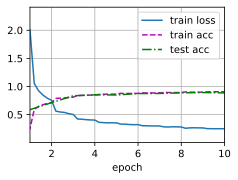

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* Inception 块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大池化层来并行抽取信息，并使用 $1×1$ 卷积层减少每像素级别上的通道维数从而降低模型复杂度。
*  GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在 ImageNet 数据集上通过大量的实验得来的。
* GoogLeNet 和它的后继者们一度是 ImageNet 上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。


## 练习

1. GoogLeNet 有数个后续版本。尝试实现并运行它们，然后观察实验结果。这些后续版本包括：
    * 添加批量归一化层 :cite:`Ioffe.Szegedy.2015`（batch normalization），在 :numref:`sec_batch_norm`中将介绍）。
    * 对 Inception 模块进行调整。
    * 使用标签平滑（label smoothing）进行模型正则化 :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`。
    * 加入残差连接 :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017` ，（ :numref:`sec_resnet` 将介绍）。
1. 使用 GoogLeNet 的最小图像大小是多少？
1. 将 AlexNet、VGG 和 NiN 的模型参数大小与 GoogLeNet 进行比较。后两个网络结构是如何显著减少模型参数大小的？


# 批量归一化
:label:`sec_batch_norm`

训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。
在本节中，我们将介绍 *批量归一化*（batch normalization） :cite:`Ioffe.Szegedy.2015` ，这是一种流行且有效的技术，可持续加速深层网络的收敛速度。
再结合在 :numref:`sec_resnet` 中将介绍的残差块，批量归一化使得研究人员能够训练 100 层以上的网络。

## 训练深层网络

为什么需要批量归一化层呢？让我们来回顾一下训练神经网络时出现的一些实际挑战。

首先，数据预处理的方式通常会对最终结果产生巨大影响。
回想一下我们应用多层感知机来预测房价的例子（ :numref:`sec_kaggle_house` ）。
使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。
直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。

第二，对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。
批量归一化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。
直观地说，我们可能会猜想，如果一个层的可变值是另一层的 100 倍，这可能需要对学习率进行补偿调整。

第三，更深层的网络很复杂，容易过拟合。
这意味着正则化变得更加重要。

批量归一化应用于单个可选层（也可以应用到所有层），其原理如下：在每次训练迭代中，我们首先归一化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。
接下来，我们应用比例系数和比例偏移。
正是由于这个基于*批量*统计的*标准化*，才有了*批量归一化*的名称。

请注意，如果我们尝试使用大小为 1 的小批量应用批量归一化，我们将无法学到任何东西。
这是因为在减去均值之后，每个隐藏单元将为 0。
所以，只有使用足够大的小批量，批量归一化这种方法才是有效且稳定的。
请注意，在应用批量归一化时，批量大小的选择可能比没有批量归一化时更重要。

从形式上来说，用 $\mathbf{x} \in \mathcal{B}$ 表示一个来自小批量 $\mathcal{B}$ 的输入，批量归一化 $\mathrm{BN}$ 根据以下表达式转换 $\mathbf{x}$：

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

在 :eqref:`eq_batchnorm` 中，$\hat{\boldsymbol{\mu}}_\mathcal{B}$ 是样本均值，$\hat{\boldsymbol{\sigma}}_\mathcal{B}$ 是小批量 $\mathcal{B}$ 的样本标准差。
应用标准化后，生成的小批量的平均值为 0 和单位方差为 1。
由于单位方差（与其他一些魔法数）是一个任意的选择，因此我们通常包含
*拉伸参数*（scale） $\boldsymbol{\gamma}$ 和 *偏移参数*（shift） $\boldsymbol{\beta}$，它们的形状与 $\mathbf{x}$ 相同。
请注意，$\boldsymbol{\gamma}$ 和 $\boldsymbol{\beta}$ 是需要与其他模型参数一起学习的参数。

由于在训练过程中，中间层的变化幅度不能过于剧烈，而批量归一化将每一层主动居中，并将它们重新调整为给定的平均值和大小（通过 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$）。

从形式上来看，我们计算出 :eqref:`eq_batchnorm` 中的 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$，如下所示：

$$\begin{aligned} \hat{\boldsymbol{\mu}}_\mathcal{B} &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.\end{aligned}$$

请注意，我们在方差估计值中添加一个小常量 $\epsilon > 0$，以确保我们永远不会尝试除以零，即使在经验方差估计值可能消失的情况下也是如此。估计值 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ 通过使用平均值和方差的噪声（noise）估计来抵消缩放问题。
你可能会认为这种噪声是一个问题，而事实上它是有益的。

事实证明，这是深度学习中一个反复出现的主题。
由于理论上尚未明确表述的原因，优化中的各种噪声源通常会导致更快的训练和较少的过拟合：这种变化似乎是正则化的一种形式。
在一些初步研究中， :cite:`Teye.Azizpour.Smith.2018` 和 :cite:`Luo.Wang.Shao.ea.2018` 分别将批量归一化的性质与贝叶斯先验相关联。
这些理论揭示了为什么批量归一化最适应 $50 \sim 100$ 范围中的中等小批量尺寸的难题。

另外，批量归一化图层在”训练模式“（通过小批量统计数据归一化）和“预测模式”（通过数据集统计归一化）中的功能不同。
在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。
而在预测模式下，可以根据整个数据集精确计算批量归一化所需的平均值和方差。

现在，我们了解一下批量归一化在实践中是如何工作的。


## 批量归一化层

回想一下，批量归一化和其他图层之间的一个关键区别是，由于批量归一化在完整的小批次上运行，因此我们不能像以前在引入其他图层时那样忽略批处理的尺寸大小。
我们在下面讨论这两种情况：全连接层和卷积层，他们的批量归一化实现略有不同。


### 全连接层

通常，我们将批量归一化层置于全连接层中的仿射变换和激活函数之间。
设全连接层的输入为 u ，权重参数和偏置参数分别为 $\mathbf{W}$ 和 $\mathbf{b}$ ，激活函数为 $\phi$ ，批量归一化的运算符为 $\mathrm{BN}$ 。
那么，使用批量归一化的全连接层的输出的计算详情如下：

$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

回想一下，均值和方差是在应用变换的"相同"小批量上计算的。


### 卷积层

同样，对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用批量归一化。
当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行批量归一化，每个通道都有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量。
假设我们的微批次包含 $m$ 个示例，并且对于每个通道，卷积的输出具有高度 $p$ 和宽度 $q$。
那么对于卷积层，我们在每个输出通道的 $m \cdot p \cdot q$ 个元素上同时执行每个批量归一化。
因此，在计算平均值和方差时，我们会收集所有空间位置的值，然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行归一化。


### 预测过程中的批量归一化

正如我们前面提到的，批量归一化在训练模式和预测模式下的行为通常不同。
首先，将训练好的模型用于预测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。
其次，例如，我们可能需要使用我们的模型对逐个样本进行预测。
一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。
可见，和 dropout 一样，批量归一化层在训练模式和预测模式下的计算结果也是不一样的。



## (**从零实现**)

下面，我们从头开始实现一个具有张量的批量归一化层。


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过 `is_grad_enabled` 来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

我们现在可以[**创建一个正确的 `BatchNorm` 图层**]。
这个层将保持适当的参数：拉伸 `gamma` 和偏移 `beta`, 这两个参数将在训练过程中更新。
此外，我们的图层将保存均值和方差的移动平均值，以便在模型预测期间随后使用。

撇开算法细节，注意我们实现图层的基础设计模式。
通常情况下，我们用一个单独的函数定义其数学原理，比如说 `batch_norm`。
然后，我们将此功能集成到一个自定义层中，其代码主要处理簿记问题，例如将数据移动到训练设备（如 GPU）、分配和初始化任何必需的变量、跟踪移动平均线（此处为均值和方差）等。
为了方便起见，我们并不担心在这里自动推断输入形状，因此我们需要指定整个特征的数量。
不用担心，深度学习框架中的批量归一化 API 将为我们解决上述问题，我们稍后将展示这一点。


In [ ]:
class BatchNorm(nn.Module):
    # `num_features`：完全连接层的输出数量或卷积层的输出通道数。
    # `num_dims`：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果 `X` 不在内存上，将 `moving_mean` 和 `moving_var`
        # 复制到 `X` 所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的 `moving_mean` 和 `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

##  使用批量归一化层的 LeNet

为了更好理解如何[**应用`BatchNorm`**]，下面我们将其应用(**于LeNet模型**)（ :numref:`sec_lenet` ）。
回想一下，批量归一化是在卷积层或全连接层之后、相应的激活函数之前应用的。


In [ ]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

和以前一样，我们将[**在Fashion-MNIST数据集上训练网络**]。
这个代码与我们第一次训练 LeNet（ :numref:`sec_lenet` ）时几乎完全相同，主要区别在于学习率大得多。


loss 0.252, train acc 0.908, test acc 0.855
35927.2 examples/sec on cuda:0


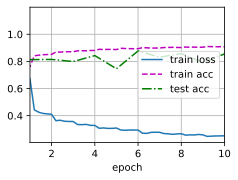

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

让我们来看看从第一个批量归一化层中学到的[**拉伸参数 `gamma` 和偏移参数 `beta`**]。


In [ ]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.8220, 1.9996, 1.6515, 2.9422, 2.8204, 2.0723], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-0.5649,  1.2251, -1.3926, -3.0136, -0.3490, -2.2020], device='cuda:0',
        grad_fn=<ViewBackward>))

## [**简明实现**]

除了使用我们刚刚定义的 `BatchNorm` ，我们也可以直接使用深度学习框架中定义的 `BatchNorm` 。
该代码看起来几乎与我们上面的代码相同。


In [ ]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))

下面，我们[**使用相同超参数来训练模型**]。
请注意，通常高级 API 变体运行速度快得多，因为它的代码已编译为 C++ 或 CUDA，而我们的自定义代码由 Python 实现。


loss 0.253, train acc 0.906, test acc 0.839
56773.4 examples/sec on cuda:0


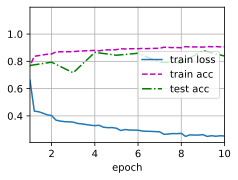

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 残差网络（ResNet）


## (**残差块**)

ResNet 沿用了 VGG 完整的 $3\times 3$ 卷积层设计。
残差块里首先有 2 个有相同输出通道数的 $3\times 3$ 卷积层。
每个卷积层后接一个批量归一化层和 ReLU 激活函数。
然后我们通过跨层数据通路，跳过这 2 个卷积运算，将输入直接加在最后的 ReLU 激活函数前。
这样的设计要求 2 个卷积层的输出与输入形状一样，从而可以相加。
如果想改变通道数，就需要引入一个额外的 $1\times 1$ 卷积层来将输入变换成需要的形状后再做相加运算。
残差块的实现如下：

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X))) # 卷积，批量归一化，激活函数
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)            # 如果要改变通道数，就必须将输入转换为需要的形状
        Y += X
        return F.relu(Y)

[**输入和输出形状一致**]的情况。


In [2]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

我们也可以在[**增加输出通道数的同时，减半输出的高和宽**]。


In [ ]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet模型**]

ResNet 的前两层跟之前介绍的 GoogLeNet 中的一样：
在输出通道数为 64、步幅为 2 的 $7 \times 7$ 卷积层后，接步幅为 2 的 $3 \times 3$ 的最大池化层。
不同之处在于 ResNet 每个卷积层后增加了批量归一化层。


In [17]:
# 前置模型
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet 在后面接了 4 个由Inception块组成的模块。
ResNet 则使用 4 个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。
第一个模块的通道数同输入通道数一致。
由于之前已经使用了步幅为 2 的最大池化层，所以无须减小高和宽。
之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。


In [18]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:   # 如果残差数量为0且不是第一块
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在 ResNet 加入所有残差块，这里每个模块使用 2 个残差块。


In [19]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) # *号加在实参数上，代表将输入迭代器拆成一个个元素
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与 GoogLeNet 一样，在 ResNet 中加入全局平均池化层，以及全连接层输出。


In [20]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),  # 这个池化层只需指定输出参数
                    nn.Flatten(), nn.Linear(512, 10))

每个模块有 4 个卷积层（不包括恒等映射的 $1\times 1$ 卷积层）。
加上第一个 $7\times 7$ 卷积层和最后一个全连接层，共有 18 层。
因此，这种模型通常被称为 ResNet-18。
通过配置不同的通道数和模块里的残差块数可以得到不同的 ResNet 模型，例如更深的含 152 层的 ResNet-152。
虽然 ResNet 的主体结构跟 GoogLeNet类似，但 ResNet 结构更简单，修改也更方便。这些因素都导致了 ResNet 迅速被广泛使用。
 :numref:`fig_resnet18` 描述了完整的 ResNet-18。

![ResNet-18 架构](http://d2l.ai/_images/resnet18.svg)
:label:`fig_resnet18`

在训练 ResNet 之前，让我们[**观察一下ResNet中不同模块的输入形状是如何变化的**]。
在之前所有架构中，分辨率降低，通道数量增加，直到全局平均池化层聚集所有特征。


In [21]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

同之前一样，我们在 Fashion-MNIST 数据集上训练 ResNet。


loss 0.013, train acc 0.997, test acc 0.915
2482.6 examples/sec on cuda:0


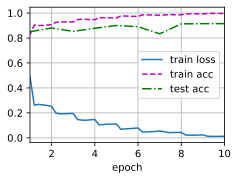

In [22]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。
* 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
* 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
* 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响，无论是卷积类网络还是全连接类网络。


## 练习

1. :numref:`fig_inception` 中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？
1. 参考 ResNet 论文 :cite:`He.Zhang.Ren.ea.2016` 中的表 1，以实现不同的变体。
1. 对于更深层次的网络，ResNet 引入了“bottleneck”架构来降低模型复杂性。请你试着去实现它。
1. 在 ResNet 的后续版本中，作者将“卷积层、批量归一化层和激活层”结构更改为“批量归一化层、激活层和卷积层”结构。请你做这个改进。详见 :cite:`He.Zhang.Ren.ea.2016*1` 中的图 1。
1. 为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？


## 争议

直观地说，批量归一化被认为可以使优化更加平滑。
然而，我们必须小心区分投机直觉和对我们观察到的现象的真实解释。
回想一下，我们甚至不知道为什么简单的神经网络（多层感知机和传统的卷积神经网络）为什么如此有效。
即使在 dropout 和权重衰减的情况下，它们仍然非常灵活，因此无法通过传统的学习理论泛化保证来解释它们是否能够概括到看不见的数据。

在提出批量归一化的论文中，作者除了介绍了其应用，还解释了其原理：通过减少 *内部协变量偏移*（internal covariate shift）。
据推测，作者所说的“内部协变量转移”类似于上述的投机直觉，即变量值的分布在训练过程中会发生变化。
然而，这种解释有两个问题：
i）这种偏移与严格定义的 *协变量偏移*（covariate shift）非常不同，所以这个名字用词不当。
ii）这种解释只提供了一种不明确的直觉，但留下了一个有待后续挖掘的问题：为什么这项技术如此有效？。
本书旨在传达实践者用来发展深层神经网络的直觉。
然而，重要的是将这些指导性直觉与既定的科学事实区分开来。
最终，当你掌握了这些方法，并开始撰写自己的研究论文时，你会希望清楚地区分技术和直觉。

随着批量归一化的普及，“内部协变量偏移”的解释反复出现在技术文献的辩论，特别是关于“如何展示机器学习研究”的更广泛的讨论中。
Ali Rahimi 在接受 2017 年 NeurIPS 大会的“接受时间考验奖”（Test of Time Award）时发表了一篇令人难忘的演讲。他将“内部协变量转移”作为焦点，将现代深度学习的实践比作炼金术。
他对该示例进行了详细回顾 :cite:`Lipton.Steinhardt.2018` ，概述了机器学习中令人不安的趋势。
此外，一些作者对批量归一化的成功提出了另一种解释：在某些方面，批量归一化的表现出与原始论文 :cite:`Santurkar.Tsipras.Ilyas.ea.2018` 中声称的行为是相反的。

然而，与技术机器学习文献中成千上万类似模糊的声明相比，内部协变量偏移没有什么更值得批评。
很可能，它作为这些辩论的焦点而产生共鸣，要归功于它对目标受众的广泛认可。
批量归一化已经证明是一种不可或缺的方法，适用于几乎所有图像分类器，在学术界获得了数万引用。



## 小结

* 在模型训练过程中，批量归一化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。
* 批量归一化在全连接层和卷积层的使用略有不同。
* 批量归一化层和 dropout 层一样，在训练模式和预测模式下计算不同。
* 批量归一化有许多有益的副作用，主要是正则化。另一方面，”减少内部协变量偏移“的原始动机似乎不是一个有效的解释。


## 练习

1. 在使用批量归一化之前，我们是否可以从全连接层或卷积层中删除偏置参数？为什么？
1. 比较LeNet在使用和不使用批量归一化情况下的学习率。
    1. 绘制训练和测试准确度的提高。
    1. 你的学习率有多高？
1. 我们是否需要在每个层中进行批量归一化？尝试一下？
1. 你可以通过批量归一化来替换 dropout 吗？行为如何改变？
1. 确定参数 `beta` 和 `gamma`，并观察和分析结果。
1. 查看高级 API 中有关 `BatchNorm` 的在线文档，以查看其他批量归一化的应用。
1. 研究思路：想想你可以应用的其他“归一化”转换？你可以应用概率积分变换吗？全秩协方差估计如何？


# 稠密连接网络（DenseNet）

ResNet极大地改变了如何参数化深层网络中函数的观点。
*稠密连接网络* (DenseNet） :cite:`Huang.Liu.Van-Der-Maaten.ea.2017` 在某种程度上是 ResNet 的逻辑扩展。让我们先从数学上了解一下。


## 从ResNet到DenseNet

回想一下任意函数的泰勒展开式（Taylor expansion），它把这个函数分解成越来越高阶的项。在 $x$ 接近 0 时，

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

同样，ResNet 将函数展开为

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

也就是说，ResNet 将 $f$ 分解为两部分：一个简单的线性项和一个更复杂的非线性项。
那么再向前拓展一步，如果我们想将 $f$ 拓展成超过两部分的信息呢？
一种方案便是 DenseNet。

![ResNet（左）与 DenseNet（右）在跨层连接上的主要区别：使用相加和使用连结。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/densenet-block.svg?raw=1)
:label:`fig_densenet_block`

如 :numref:`fig_densenet_block` 所示，ResNet 和 DenseNet 的关键区别在于，DenseNet 输出是*连接*（用图中的 $[,]$ 表示）而不是如 ResNet 的简单相加。
因此，在应用越来越复杂的函数序列后，我们执行从 $\mathbf{x}$ 到其展开式的映射：

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。
实现起来非常简单：我们不需要添加术语，而是将它们连接起来。
DenseNet 这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。
稠密连接如 :numref:`fig_densenet` 所示。

![稠密连接。](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`

稠密网络主要由 2 部分构成： *稠密块*（dense block）和 *过渡层* （transition layer）。
前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。


## (**稠密块体**)

DenseNet 使用了 ResNet 改良版的“批量归一化、激活和卷积”结构（参见 :numref:`sec_resnet` 中的练习）。
我们首先实现一下这个结构。


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

一个*稠密块*由多个卷积块组成，每个卷积块使用相同数量的输出信道。
然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。


In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(
                conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

在下面的例子中，我们[**定义一个**]有 2 个输出通道数为 10 的 (**`DenseBlock`**)。
使用通道数为 3 的输入时，我们会得到通道数为 $3+2\times 10=23$ 的输出。
卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为*增长率*（growth rate）。


In [ ]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## [**过渡层**]

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。
而过渡层可以用来控制模型复杂度。
它通过 $1\times 1$ 卷积层来减小通道数，并使用步幅为 2 的平均池化层减半高和宽，从而进一步降低模型复杂度。


In [ ]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

对上一个例子中稠密块的输出[**使用**]通道数为 10 的[**过渡层**]。
此时输出的通道数减为 10，高和宽均减半。


In [ ]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## [**DenseNet模型**]

我们来构造 DenseNet 模型。DenseNet 首先使用同 ResNet 一样的单卷积层和最大池化层。


In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

接下来，类似于 ResNet 使用的 4 个残差块，DenseNet 使用的是 4 个稠密块。
与 ResNet 类似，我们可以设置每个稠密块使用多少个卷积层。
这里我们设成 4，从而与 :numref:`sec_resnet` 的 ResNet-18 保持一致。
稠密块里的卷积层通道数（即增长率）设为 32，所以每个稠密块将增加 128 个通道。

在每个模块之间，ResNet 通过步幅为 2 的残差块减小高和宽，DenseNet 则使用过渡层来减半高和宽，并减半通道数。


In [ ]:
# `num_channels`为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

与 ResNet 类似，最后接上全局池化层和全连接层来输出结果。


In [ ]:
net = nn.Sequential(b1, *blks, nn.BatchNorm2d(num_channels), nn.ReLU(),
                    nn.AdaptiveMaxPool2d((1, 1)), nn.Flatten(),
                    nn.Linear(num_channels, 10))

## [**训练模型**]

由于这里使用了比较深的网络，本节里我们将输入高和宽从 224 降到 96 来简化计算。


loss 0.150, train acc 0.945, test acc 0.858
5508.4 examples/sec on cuda:0


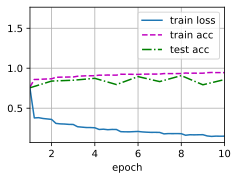

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 在跨层连接上，不同于 ResNet 中将输入与输出相加，稠密连接网络（DenseNet）在通道维上连结输入与输出。
* DenseNet 的主要构建模块是稠密块和过渡层。
* 在构建 DenseNet 时，我们需要通过添加过渡层来控制网络的维数，从而再次减少信道的数量。


## 练习

1. 为什么我们在过渡层使用平均池化层而不是最大池化层？
1. DenseNet 的优点之一是其模型参数比 ResNet 小。为什么呢？
1. DenseNet 一个诟病的问题是内存或显存消耗过多。
    1. 真的是这样吗？可以把输入形状换成 $224 \times 224$ ，来看看实际的显存消耗。
    1. 你能想出另一种方法来减少显存消耗吗？你需要如何改变框架？
1. 实现 DenseNet 论文 :cite:`Huang.Liu.Van-Der-Maaten.ea.2017` 表 1 所示的不同 DenseNet 版本。
1. 应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于 :numref:`sec_kaggle_house` 中的房价预测任务。
